In [ ]:
# Loading the MNIST dataset directly from keras
from keras.datasets import mnist
(train_input, train_output), (test_input, test_output) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


#Data exploration  and preprocessing

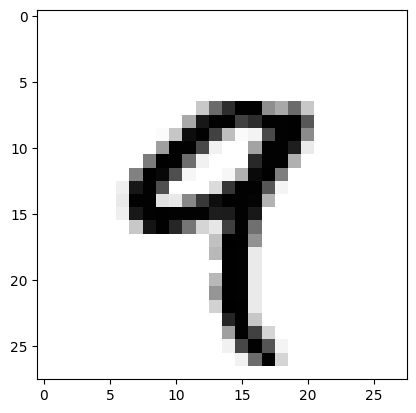

Train input shape: (60000, 28, 28)
Test input shape: (10000, 28, 28)


In [ ]:
# Displaying a train input digit with matplotlib
import matplotlib.pyplot as plt
import numpy as np
digit = train_input[4]
plt.imshow(digit, cmap=plt.cm.binary)
plt.show()

print(f'Train input shape: {np.shape(train_input)}')
print(f'Test input shape: {np.shape(test_input)}')

In [ ]:
# Preprocessing the input data

train_input_dense_nn = train_input.reshape((train_input.shape[0], 28*28))
train_input_dense_nn = train_input_dense_nn.astype('float32') / 255
test_input_dense_nn = test_input.reshape((test_input.shape[0], 28*28))
test_input_dense_nn = test_input_dense_nn.astype('float32') / 255

train_input_convolutional_nn = train_input.reshape((train_input.shape[0], 28, 28, 1))
train_input_convolutional_nn = train_input_convolutional_nn.astype('float32') / 255
test_input_convolutional_nn = test_input.reshape((test_input.shape[0], 28, 28, 1))
test_input_convolutional_nn = test_input_convolutional_nn.astype('float32') / 255

In [ ]:
# Categorically encoding the label data
from keras.utils import to_categorical
train_output_dense_nn = to_categorical(train_output)
test_output_dense_nn = to_categorical(test_output)

train_output_convolutional_nn = to_categorical(train_output)
test_output_convolutional_nn = to_categorical(test_output)

#Model arquitecture function


In [ ]:
# Importing the keras sequential model
from keras import models, layers, losses, optimizers, metrics, regularizers

def buildDenseNN(layers_units, shape):
  model = models.Sequential()
  model.add(layers.Dense(layers_units[0], activation="relu", kernel_regularizer=regularizers.l2(0.001), input_shape=shape))

  for i in layers_units[1:]:
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(i, activation="relu", kernel_regularizer=regularizers.l2(0.001)))

  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation="softmax"))

  model.compile(
      optimizer=optimizers.RMSprop(),
      loss=losses.categorical_crossentropy,
      metrics=["accuracy"]
  )

  return model

def buildConvolutionalNN(layers_units, dense_layer_units, window_size, pooling_size, shape):
  model = models.Sequential()

  # Feature extraction layers
  model.add(layers.Conv2D(layers_units[0], window_size[0], activation="relu", input_shape=shape))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D(pooling_size[0]))

  for i in range(len(layers_units[1:len(layers_units)-1])):
    model.add(layers.Conv2D(layers_units[i], window_size[i], activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pooling_size[i]))

  model.add(layers.Conv2D(layers_units[len(layers_units)-1], window_size[len(window_size)-1], activation="relu"))

  # Classifier
  model.add(layers.Flatten())
  model.add(layers.Dense(dense_layer_units, activation="relu"))
  model.add(layers.Dropout(0.4))
  model.add(layers.Dense(10, activation="softmax"))

  model.compile(
      optimizer=optimizers.RMSprop(),
      loss=losses.categorical_crossentropy,
      metrics=["accuracy"]
  )

  return model

#Creating the K Fold Shuffled Cross-Validation algorithm for each model

In [ ]:
# Creating the K Fold Cross-Validation algorithm
import numpy as np

def shuffleData(data_input, data_output):
  data_length = len(data_input)
  permutation = np.random.permutation(data_length)

  data_input = data_input[permutation]
  data_output = data_output[permutation]

def fitModel(model, data_input, data_output, val_input, val_output, batch_size, N_epochs, verbose=1):
  history = model.fit(data_input, data_output, validation_data=(val_input, val_output), batch_size=batch_size, epochs=N_epochs, verbose=verbose)
  return history

def kFoldCrossValidationDeepNN(buildModelFunction, k, data_input, data_output, batch_size, N_epochs, layer_units, shape):
  shuffleData(data_input, data_output)
  data_length = len(data_input)
  N = data_length//k
  k_folds_history = list()

  for i in range(k):
    print(f'Processing fold', i)
    data_input_val_partition = data_input[i*N:(i+1)*N]
    data_input_train_partition = np.concatenate(
      [data_input[:i*N], data_input[(i+1)*N:]], axis=0
    )

    data_output_val_partition = data_output[i*N:(i+1)*N]
    data_output_train_partition = np.concatenate(
        [data_output[:i*N], data_output[(i+1)*N:]], axis=0
    )

    model = buildModelFunction(layer_units, shape)
    history = fitModel(model, data_input_train_partition, data_output_train_partition, data_input_val_partition, data_output_val_partition, batch_size, N_epochs, verbose=0)
    k_folds_history.append(history.history)

  return k_folds_history

def kFoldCrossValidationConvNN(buildModelFunction, k, data_input, data_output, batch_size, N_epochs, layers_units, dense_layer_units, window_size, pooling_size, shape):
  shuffleData(data_input, data_output)
  data_length = len(data_input)
  N = data_length//k
  k_folds_history = list()

  for i in range(k):
    print(f'Processing fold', i)
    data_input_val_partition = data_input[i*N:(i+1)*N]
    data_input_train_partition = np.concatenate(
      [data_input[:i*N], data_input[(i+1)*N:]], axis=0
    )

    data_output_val_partition = data_output[i*N:(i+1)*N]
    data_output_train_partition = np.concatenate(
        [data_output[:i*N], data_output[(i+1)*N:]], axis=0
    )

    model = buildModelFunction(layers_units, dense_layer_units, window_size, pooling_size, shape)
    history = fitModel(model, data_input_train_partition, data_output_train_partition, data_input_val_partition, data_output_val_partition, batch_size, N_epochs, verbose=0)
    k_folds_history.append(history.history)

  return k_folds_history

#Creating the Dense NN Model

In [ ]:
k_folds_history_deep_nn = kFoldCrossValidationDeepNN(buildDenseNN, 4, train_input_dense_nn, train_output_dense_nn, 512, 20, [512, 64], (28*28, ))

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [ ]:
epoch_accuracy_mean_deep_nn = [np.mean([x["accuracy"][i] for x in k_folds_history_deep_nn]) for i in range(len(k_folds_history_deep_nn[0]["accuracy"]))]
epoch_val_accuracy_mean_deep_nn = [np.mean([x["val_accuracy"][i] for x in k_folds_history_deep_nn]) for i in range(len(k_folds_history_deep_nn[0]["val_accuracy"]))]

Maximum validation accuracy: 0.9732833504676819 at epoch 20


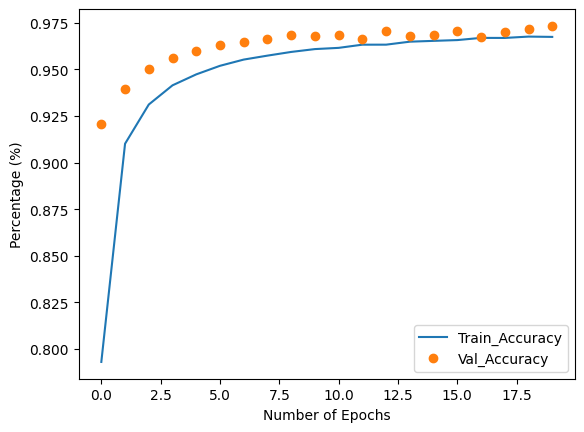

In [ ]:
# Ploting the data from history. Notice the max accuracy is reached at epoch 19
import matplotlib.pyplot as plt

plt.plot(epoch_accuracy_mean_deep_nn, label="Train_Accuracy")
plt.plot(epoch_val_accuracy_mean_deep_nn, 'o', label="Val_Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Percentage (%)")
plt.legend()

print(
    f'Maximum validation accuracy: {max(epoch_val_accuracy_mean_deep_nn)} at epoch {epoch_val_accuracy_mean_deep_nn.index(max(epoch_val_accuracy_mean_deep_nn))+1}'
)

In [ ]:
denseNN = buildDenseNN([512, 64], (28*28, ))
denseNN.fit(train_input_dense_nn, train_output_dense_nn, batch_size=512, epochs=18, )

Epoch 1/18
118/118 [==============================] - 5s 37ms/step - loss: 1.1433 - accuracy: 0.8197
Epoch 2/18
118/118 [==============================] - 3s 28ms/step - loss: 0.6093 - accuracy: 0.9196
Epoch 3/18
118/118 [==============================] - 3s 27ms/step - loss: 0.4539 - accuracy: 0.9384
Epoch 4/18
118/118 [==============================] - 4s 30ms/step - loss: 0.3764 - accuracy: 0.9467
Epoch 5/18
118/118 [==============================] - 4s 34ms/step - loss: 0.3311 - accuracy: 0.9518
Epoch 6/18
118/118 [==============================] - 3s 28ms/step - loss: 0.3052 - accuracy: 0.9546
Epoch 7/18
118/118 [==============================] - 3s 28ms/step - loss: 0.2818 - accuracy: 0.9577
Epoch 8/18
118/118 [==============================] - 4s 36ms/step - loss: 0.2710 - accuracy: 0.9584
Epoch 9/18
118/118 [==============================] - 3s 28ms/step - loss: 0.2574 - accuracy: 0.9609
Epoch 10/18
118/118 [==============================] - 3s 28ms/step - loss: 0.2476 - accura

In [ ]:
denseNN.evaluate(test_input_dense_nn, test_output_dense_nn)

313/313 [==============================] - 2s 5ms/step - loss: 0.1745 - accuracy: 0.9772


[0.17445413768291473, 0.9771999716758728]

#Creating the Convolutional NN Model

In [ ]:
k_folds_history_conv_nn = kFoldCrossValidationConvNN(buildConvolutionalNN, 4, train_input_convolutional_nn, train_output_convolutional_nn, 64, 5, [32, 64, 64], 64, [(3, 3), (3, 3), (3, 3)], [(2, 2), (2, 2)], (28, 28, 1))

Processing fold 0
Processing fold 1
Processing fold 2
Processing fold 3


In [ ]:
epoch_accuracy_mean_conv_nn = [np.mean([x["accuracy"][i] for x in k_folds_history_conv_nn]) for i in range(len(k_folds_history_conv_nn[0]["accuracy"]))]
epoch_val_accuracy_mean_conv_nn = [np.mean([x["val_accuracy"][i] for x in k_folds_history_conv_nn]) for i in range(len(k_folds_history_conv_nn[0]["val_accuracy"]))]

Maximum validation accuracy: 0.9858166724443436 at epoch 5


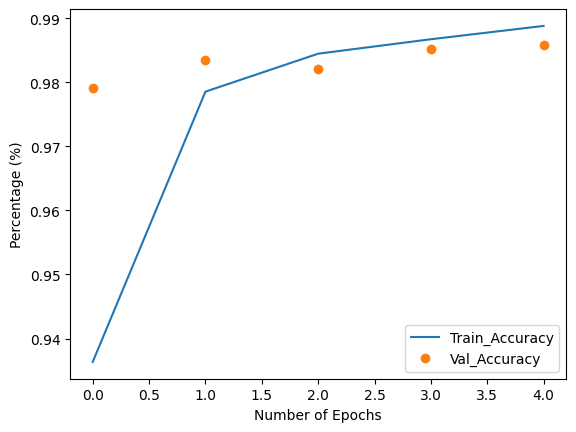

In [ ]:
# Ploting the data from history. Notice the max accuracy is reached at epoch 4
import matplotlib.pyplot as plt

plt.plot(epoch_accuracy_mean_conv_nn, label="Train_Accuracy")
plt.plot(epoch_val_accuracy_mean_conv_nn, 'o', label="Val_Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Percentage (%)")
plt.legend()

print(
    f'Maximum validation accuracy: {max(epoch_val_accuracy_mean_conv_nn)} at epoch {epoch_val_accuracy_mean_conv_nn.index(max(epoch_val_accuracy_mean_conv_nn))+1}'
)

In [ ]:
convNN = buildConvolutionalNN([32, 64, 64], 64, [(3, 3), (3, 3), (3, 3)], [(2, 2), (2, 2)], (28, 28, 1))
convNN.fit(train_input_convolutional_nn, train_output_convolutional_nn, batch_size=64, epochs=5)

Epoch 1/5
938/938 [==============================] - 54s 56ms/step - loss: 0.2014 - accuracy: 0.9405
Epoch 2/5
938/938 [==============================] - 53s 56ms/step - loss: 0.0690 - accuracy: 0.9814
Epoch 3/5
938/938 [==============================] - 53s 56ms/step - loss: 0.0553 - accuracy: 0.9851
Epoch 4/5
938/938 [==============================] - 53s 57ms/step - loss: 0.0463 - accuracy: 0.9875
Epoch 5/5
938/938 [==============================] - 54s 57ms/step - loss: 0.0419 - accuracy: 0.9893


In [ ]:
convNN.evaluate(test_input_convolutional_nn, test_output_convolutional_nn)

313/313 [==============================] - 4s 12ms/step - loss: 0.0416 - accuracy: 0.9888


[0.04156793653964996, 0.9887999892234802]